This version:
* Reads data from a CSV file using pandas (Spark to come later)
* Does no preprocessing (where Spark should really help for large datasets
* Doesn't do anything about class imbalance except to look at recall and precision
* Trains both a sklearn (random forest) and a neural network (PyTorch) model
* Is not how a data scientist at a bank would build a statistically robust model

# Install and load packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
import os, boto3, time, operator, requests
import numpy as np
import pandas as pd

#Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
from sklearn.externals import joblib

#Plotting
import matplotlib.pylab as plt
import matplotlib.colors

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Ingestion and Basic Exploration

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
print('Distribution of labels: Extreme class imbalance')
df['Class'].value_counts()

Distribution of labels: Extreme class imbalance


0    284315
1       492
Name: Class, dtype: int64

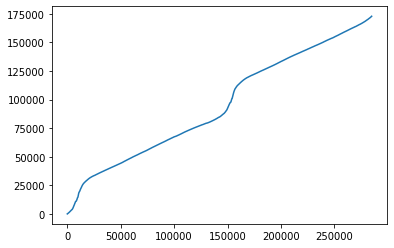

In [9]:
plt.plot(df['Time'])

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Train-test split

In [12]:
df_train, df_test = train_test_split(df, train_size=0.8)

/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
print(df_train.shape)
df_train['Class'].value_counts()

(227845, 31)


0    227449
1       396
Name: Class, dtype: int64

In [16]:
print(df_test.shape)
df_test['Class'].value_counts()

(56962, 31)


0    56866
1       96
Name: Class, dtype: int64

# Train Sklearn Random Forest Model

In [20]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=10)

model.fit(df_train.drop('Class', axis=1), df_train['Class'])

pred_train_prob = model.predict_proba(df_train.drop('Class', axis=1))
pred_test_prob = model.predict_proba(df_test.drop('Class', axis=1))

pred_train = model.predict(df_train.drop('Class', axis=1))
pred_test = model.predict(df_test.drop('Class', axis=1))

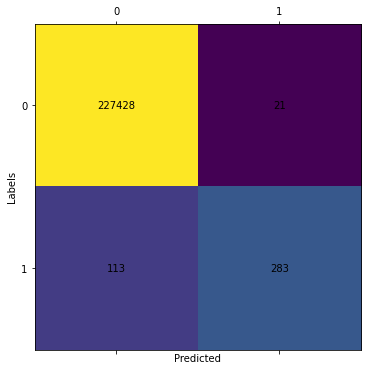

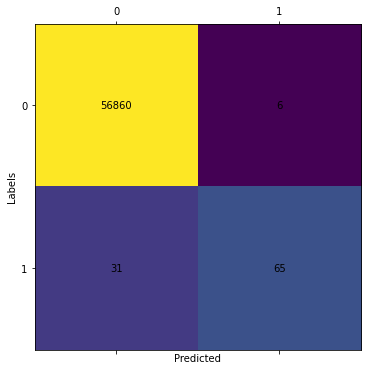

In [38]:
def plot_confusion_matrix(df, pred):
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    unique_labels = df['Class'].unique()
    N = len(unique_labels)
    confusion = confusion_matrix(df['Class'], pred)
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(N))
    ax.set_yticks(range(N))

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    for i in range(N):
        for j in range(N):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('Predicted')
    plt.ylabel('Labels')

plot_confusion_matrix(df_train, pred_train);
plot_confusion_matrix(df_test, pred_test)

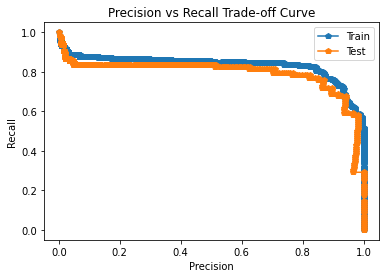

In [47]:
def plot_precision_recall_curve(df, pred_prob, label):
    precision, recall, thresholds = precision_recall_curve(df['Class'], pred_prob[:,1])
    plt.plot(precision, recall, 'p-', label=label)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall Trade-off Curve')
    plt.grid()
    plt.legend()
    
plot_precision_recall_curve(df_train, pred_train_prob, 'Train')
plot_precision_recall_curve(df_test, pred_test_prob, 'Test')

# Train PyTorch Neural Network Model

In [56]:
np.array(df.iloc[0])[1:df.shape[1]]

array([-1.35980713e+00, -7.27811733e-02,  2.53634674e+00,  1.37815522e+00,
       -3.38320770e-01,  4.62387778e-01,  2.39598554e-01,  9.86979013e-02,
        3.63786970e-01,  9.07941720e-02, -5.51599533e-01, -6.17800856e-01,
       -9.91389847e-01, -3.11169354e-01,  1.46817697e+00, -4.70400525e-01,
        2.07971242e-01,  2.57905802e-02,  4.03992960e-01,  2.51412098e-01,
       -1.83067779e-02,  2.77837576e-01, -1.10473910e-01,  6.69280749e-02,
        1.28539358e-01, -1.89114844e-01,  1.33558377e-01, -2.10530535e-02,
        1.49620000e+02,  0.00000000e+00])

In [57]:
np.array(df.iloc[0])[-1]

0.0

In [48]:
N_hidden = 128
N_output = 1

net = nn.Sequential(nn.Linear(df_train.shape[1], N_hidden),
                    nn.ReLU(),
                    nn.Linear(N_hidden, N_output),
                   )

criterion = nn.BCEWithLogitsLoss()

class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.N_cols = df.shape[1]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        x = np.array(self.df[ix])
        features = x[1:(self.N_cols-1)]) #exclude time, Class
        label = x[-1]
        
        return {'features': features, 'label': label}

def train_net(model, criterion, lr, df, batch_size):
    

# Check the Important Features

In [ ]:

%matplotlib inline
import operator
import matplotlib.pylab as plt

feat_imp = sorted(zip(features_train_pd.columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in feat_imp], [i[1] for i in feat_imp], 'p-')
_ = plt.xticks(rotation=90)

# Re-create the model with Important Features

In [ ]:
#Define features and target variables for convenience.
## From the graph we only want seven important features V3,V4,V10,V11,V12,V14,V17
drop_time_class = ['_c0', 'Time', 'Class','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
drop_class=['Class']


features_train = df_train.drop(*drop_time_class)
target_train = df_train.select("Class")

features_test = df_test.drop(*drop_time_class)
target_test = df_test.select("Class")
features_test.printSchema()

model = RandomForestClassifier(n_estimators=200, max_depth=6, n_jobs=10, class_weight='balanced')
                               
#Convert to pandas
features_test_pd = features_test.toPandas()
target_test_pd = target_test.toPandas()

features_train_pd = features_train.toPandas()
target_train_pd = target_train.toPandas()

model.fit(features_train_pd, target_train_pd.values.ravel())

pred_train = model.predict(features_train_pd)
pred_test = model.predict(features_test_pd)

pred_train_prob = model.predict_proba(features_train_pd)
pred_test_prob = model.predict_proba(features_test_pd)

print("Number of features")
print(len(model.feature_importances_))
  
#save mode in filesystem
joblib.dump(model, 'model.pkl') 

# Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(target_train_pd, model.predict(features_train_pd))

_ = plot_confusion_matrix(target_test_pd, model.predict(features_test_pd))

# Test New Model

In [ ]:
import json
import pandas as pd
import numpy as np
import time


df_test_pandas = df_test.toPandas()
fraudTest = df_test_pandas.loc[df_test_pandas['Class']== 1]
notFraudTest = df_test_pandas.loc[df_test_pandas['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
notFraudTestFeatures = notFraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])

for index, row in fraudTestFeatures.iterrows():
    data = row
    rowdf = pd.DataFrame([data.tolist()], columns = ['V3','V4','V10','V11','V12','V14','V17','Amount'])
    print(model.predict(rowdf))
    time.sleep(2)




# Upload Model to Rook/Ceph

In [ ]:
import boto3

key = "uploaded/model.pkl"
s3.upload_file(Bucket=s3_bucket, Key=key, Filename="model.pkl")
prefix='uploaded/'
result = s3.list_objects(Bucket=s3_bucket, Prefix=prefix, Delimiter='/')
print(result)

# Install OpenShift client

In [ ]:
%%bash
curl -o oc.tar.gz -L https://mirror.openshift.com/pub/openshift-v3/clients/4.0.22/linux/oc.tar.gz
tar xzf oc.tar.gz
cp oc ~/../bin/oc


# Login into Cluster

In [ ]:
%%bash

oc login -u <INSERT USERNAME> -p <INSERT PASSWORD> --insecure-skip-tls-verify <INSERT CLUSTER URL>:6443
oc project frauddetection

# Serve Model With Seldon

In [ ]:
%%bash
oc project frauddetection
oc create -n frauddetection -f https://raw.githubusercontent.com/nakfour/odh-kubeflow/master/mymodel.json
oc get seldondeployments

# Test Served Full Model in Curl

In [ ]:
%%bash
cp jq ~/../bin/jq
chmod 777 ~/../bin/jq
export TOKENJSON=$(curl -XPOST -u oauth-key:oauth-secret <INSERT SELDON API SERVER URL>/oauth/token -d 'grant_type=client_credentials')
export TOKEN=$(echo $TOKENJSON | jq ".access_token" -r)
echo $TOKEN

curl -v --header "Authorization: Bearer $TOKEN" <INSERT SELDON API SERVER URL>/api/v0.1/predictions -d '{"strData": "0.365194527642578,0.819750231339882,-0.5927999453145171,-0.619484351930421,-2.84752569239798,1.48432160780265,0.499518887687186,72.98"}' -H "Content-Type: application/json"

# Test Served Full Model In Python

In [ ]:
### Testing the served model from python using the test dataframe
import requests
import time

# Get the token
post_data = {"grant_type": "client_credentials"}
requestOauth = requests.post('<INSERT SELDON API SERVER URL>/oauth/token', auth=('oauth-key', 'oauth-secret'), data=post_data, json={'grant_type=client_credentials'})

data = requestOauth.json();
print(data['access_token'])
access_token = data['access_token']

headers = {'Content-type': 'application/json', 'Authorization': 'Bearer {}'.format(access_token)}
#Read the test dataframe and stream each row
df_test_pandas = df_test.toPandas()
fraudTest = df_test_pandas.loc[df_test_pandas['Class']== 1]
notFraudTest = df_test_pandas.loc[df_test_pandas['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
notFraudTestFeatures = notFraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
#for index, row in features_test.toPandas().iterrows():
for index, row in fraudTestFeatures.iterrows():
    data = row
    str1 = ','.join(str(e) for e in  data)
    requestPrediction = requests.post('<INSERT SELDON API SERVER URL>/api/v0.1/predictions', headers=headers, json={"strData": str1 })
    predictionData = requestPrediction.json();
    datafield = predictionData['data']
    predictionArray = datafield['ndarray']
    print(predictionArray[0])
    time.sleep(2)

# Clear Demo

In [ ]:
%%bash
oc project frauddetection
oc delete seldondeployments mymodel

